# ToledoWallaye Feature Selection
* StellarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* October 28, 2021

## Hypothesis
Write about the hunch you have and why you're running this experiment.

## Experiment
Document the experiment including selecting data, data transformations, feature engineering and modelling

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
from pycaret.classification import *
from ngboost import NGBClassifier

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'nrad' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password········


In [3]:
lkupclientid = 52 # toledoWallaye

cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrAHL].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

CNXN.commit()
cursor.close()

df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8036 entries, 0 to 8035
Data columns (total 55 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lkupClientId              8036 non-null   int64  
 1   dimCustomerMasterId       8036 non-null   int64  
 2   customerNumber            8036 non-null   object 
 3   year                      8036 non-null   object 
 4   productGrouping           8036 non-null   object 
 5   totalSpent                8036 non-null   float64
 6   recentDate                8036 non-null   object 
 7   attendancePercent         8036 non-null   float64
 8   renewedBeforeDays         8036 non-null   int64  
 9   isBuyer                   8036 non-null   object 
 10  source_tenure             8036 non-null   int64  
 11  tenure                    8036 non-null   int64  
 12  distToVenue               8036 non-null   float64
 13  totalGames                8036 non-null   int64  
 14  recency 

### Let's drop the features that have lots of null values:

In [4]:
df.drop([ 
    'lengthOfResidenceInYrs',
    'annualHHIncome',
    'education',
    'urbanicity',
    'isnextyear_buyer',
    'isnextyear_samepkg_buyer',
    'pkgupgrade_status',
    'auto_renewal'],
    axis=1, 
    inplace=True
)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8036 entries, 0 to 8035
Data columns (total 47 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   lkupClientId          8036 non-null   int64  
 1   dimCustomerMasterId   8036 non-null   int64  
 2   customerNumber        8036 non-null   object 
 3   year                  8036 non-null   object 
 4   productGrouping       8036 non-null   object 
 5   totalSpent            8036 non-null   float64
 6   recentDate            8036 non-null   object 
 7   attendancePercent     8036 non-null   float64
 8   renewedBeforeDays     8036 non-null   int64  
 9   isBuyer               8036 non-null   object 
 10  source_tenure         8036 non-null   int64  
 11  tenure                8036 non-null   int64  
 12  distToVenue           8036 non-null   float64
 13  totalGames            8036 non-null   int64  
 14  recency               8036 non-null   int64  
 15  missed_games_1       

### In order to compare two sets of features, we need to create some datasets for training and evalution:

In [5]:
df_train_A = df.sample(frac=0.9, random_state=786)
df_train_B = df.sample(frac=0.9, random_state=786)

df_eval_A = df.drop(df_train_A.index)
df_eval_B = df.drop(df_train_B.index)

print('Data for Modeling (A Class): ' + str(df_train_A.shape))
print('Unseen Data For Predictions: ' + str(df_eval_A.shape))

print('Data for Modeling (A Class): ' + str(df_train_A.shape))
print('Unseen Data For Predictions: ' + str(df_eval_A.shape))

Data for Modeling (A Class): (7232, 47)
Unseen Data For Predictions: (804, 47)
Data for Modeling (A Class): (7232, 47)
Unseen Data For Predictions: (804, 47)


### Let's also drop the features that only have a single value, as they won't add much differentiation to our model:

In [6]:
for col in df.columns:
    if len(df[col].unique()) == 1:
        df.drop(col,inplace=True,axis=1)
        
df.shape

(8036, 17)

### We should also drop features that have a low correlation with the target label as they won't be useful for prediction, we'll only keep features that have a correlation above a set threshold:

In [7]:
cor = df.corr()

threshold = 0.05

#Correlation with output variable
cor_target = abs(cor["isNextYear_Buyer"])

#Selecting highly correlated features
relevant_features = cor_target[cor_target > threshold]

feats = []
for name, val in relevant_features.items():
    feats.append(name)

df_correlated = df[feats]

df_correlated.shape

df_correlated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8036 entries, 0 to 8035
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dimCustomerMasterId  8036 non-null   int64  
 1   attendancePercent    8036 non-null   float64
 2   renewedBeforeDays    8036 non-null   int64  
 3   tenure               8036 non-null   int64  
 4   totalGames           8036 non-null   int64  
 5   missed_games_1       8036 non-null   int64  
 6   missed_games_over_2  8036 non-null   int64  
 7   isNextYear_Buyer     8036 non-null   int64  
dtypes: float64(1), int64(7)
memory usage: 502.4 KB


### Now that we have the right features we can look at the correlations between them, if features are highly correlated with each other it might negatively impact the model:

In [8]:
corr = df_correlated.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,dimCustomerMasterId,attendancePercent,renewedBeforeDays,tenure,totalGames,missed_games_1,missed_games_over_2,isNextYear_Buyer
dimCustomerMasterId,1.00,-0.01,-0.07,-0.21,0.00,0.08,-0.14,-0.09
attendancePercent,-0.01,1.00,-0.47,0.16,0.63,0.34,-0.19,-0.11
renewedBeforeDays,-0.07,-0.47,1.00,-0.10,-0.34,-0.51,0.33,0.19
tenure,-0.21,0.16,-0.10,1.00,0.20,-0.14,-0.07,-0.07
totalGames,0.00,0.63,-0.34,0.20,1.00,0.16,-0.29,-0.18
missed_games_1,0.08,0.34,-0.51,-0.14,0.16,1.00,-0.55,-0.31
missed_games_over_2,-0.14,-0.19,0.33,-0.07,-0.29,-0.55,1.00,0.58
isNextYear_Buyer,-0.09,-0.11,0.19,-0.07,-0.18,-0.31,0.58,1.00


### In order to compare two sets of features, we need to create some datasets for training and evalution:


In [9]:
# select % of the data for training
df_train = df_correlated.sample(frac=0.8, random_state=786).reset_index(drop=True)

# create the eval datasets for A and B
df_eval = df_correlated.drop(df_train.index).reset_index(drop=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (6429, 8)
Unseen Data For Predictions: (1607, 8)



## Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [10]:
from sklearn.impute import SimpleImputer
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.80,
    data_split_shuffle=True,
    silent=True,
    numeric_features=[
        "attendancePercent",
        "renewedBeforeDays",
        "tenure",
        "totalGames",
        "missed_games_1",
        "missed_games_over_2"
    ]
)

,Description,Value
0,session_id,8848
1,Target,isNextYear_Buyer
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(6429, 8)"
5,Missing Values,False
6,Numeric Features,7
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


('isNextYear_Buyer',
 'clf-default-name',
 None,
 'b4ac',
 {'lr': <pycaret.containers.models.classification.LogisticRegressionClassifierContainer at 0x7fd6e1d9a890>,
  'knn': <pycaret.containers.models.classification.KNeighborsClassifierContainer at 0x7fd6e1d9a990>,
  'nb': <pycaret.containers.models.classification.GaussianNBClassifierContainer at 0x7fd6e1d9aad0>,
  'dt': <pycaret.containers.models.classification.DecisionTreeClassifierContainer at 0x7fd6e1d9ab90>,
  'svm': <pycaret.containers.models.classification.SGDClassifierContainer at 0x7fd6e1d9ae10>,
  'rbfsvm': <pycaret.containers.models.classification.SVCClassifierContainer at 0x7fd6e1c62e90>,
  'gpc': <pycaret.containers.models.classification.GaussianProcessClassifierContainer at 0x7fd6e1c62d50>,
  'mlp': <pycaret.containers.models.classification.MLPClassifierContainer at 0x7fd6e1c62c90>,
  'ridge': <pycaret.containers.models.classification.RidgeClassifierContainer at 0x7fd6e1c62a10>,
  'rf': <pycaret.containers.models.classif

In [11]:
# adding an extra classifier ngboost
ngc = NGBClassifier()
ngboost = create_model(ngc)

model_matrix = compare_models(
    fold=10,
    include=["ada","dt","gbc","et","knn","lightgbm","lr","rf",ngboost,"xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
2,Gradient Boosting Classifier,0.8647,0.9286,0.8173,0.7467,0.7796,0.6824,0.6846,0.1020
5,Light Gradient Boosting Machine,0.8623,0.9281,0.7940,0.7514,0.7715,0.6732,0.6743,0.0330
0,Ada Boost Classifier,0.8614,0.9258,0.8252,0.7355,0.7771,0.6771,0.6801,0.0510
8,NGBClassifier,0.8561,0.9193,0.8399,0.7177,0.7736,0.6691,0.6740,1.5370
7,Random Forest Classifier,0.8555,0.9224,0.7748,0.7437,0.7584,0.6555,0.6562,0.2290
9,Extreme Gradient Boosting,0.8518,0.9217,0.7668,0.7390,0.7517,0.6463,0.6473,0.3320
3,Extra Trees Classifier,0.8398,0.9115,0.7535,0.7159,0.7334,0.6191,0.6202,0.2040
1,Decision Tree Classifier,0.8089,0.7690,0.6731,0.6749,0.6732,0.5382,0.5389,0.0080
4,K Neighbors Classifier,0.7093,0.7258,0.4625,0.5038,0.4816,0.2804,0.2813,0.0490
6,Logistic Regression,0.7036,0.7095,0.2036,0.3900,0.2364,0.1144,0.1196,0.0110


### The top model is performing well, so let's compare it against our unseen eval dataset:


In [12]:
best_model = create_model(model_matrix)

unseen_predictions = predict_model(best_model, data=df_eval)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8913,0.9501,0.8543,0.7914,0.8217,0.7436,0.7447
1,0.8583,0.9243,0.8079,0.7349,0.7697,0.6677,0.6692
2,0.8602,0.9348,0.8675,0.7158,0.7844,0.6824,0.6893
3,0.8755,0.9228,0.7800,0.7905,0.7852,0.6976,0.6976
4,0.8755,0.9316,0.8533,0.7529,0.8000,0.7101,0.7130
5,0.8541,0.9253,0.7867,0.7329,0.7588,0.6544,0.6553
6,0.8444,0.9202,0.8133,0.7011,0.7531,0.6404,0.6441
7,0.8444,0.9161,0.8200,0.6989,0.7546,0.6417,0.6461
8,0.8716,0.9308,0.7881,0.7778,0.7829,0.6917,0.6918
9,0.8716,0.9298,0.8013,0.7707,0.7857,0.6941,0.6944


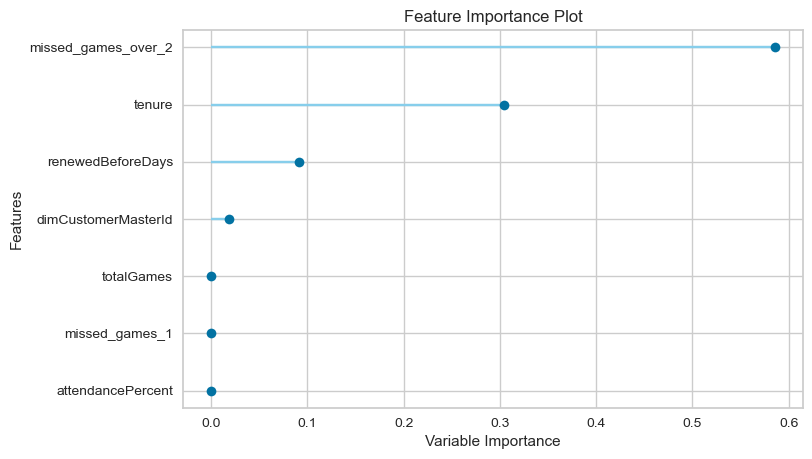

In [13]:
plot_model(best_model, plot='feature')

In [21]:
plot_model(best_model, plot='confusion_matrix')

IntProgress(value=0, description='Processing: ', max=5)

Finished loading model, total used 100 iterations


AttributeError: 'Pipeline' object has no attribute 'fig'

## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?